Load and Split data

In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
train_path = "./dataset/test.txt"
test_path = "./dataset/test.txt"
val_path = "./dataset/val.txt"

In [3]:
def read_data(path):
    return pd.read_csv(path,delimiter=';',names=["text","emotion"])

In [4]:
train_data = read_data(train_path)
test_data = read_data(test_path)
val_data = read_data(val_path)

In [5]:
labelEncoder = LabelEncoder()
train_data["emotion"] = labelEncoder.fit_transform(train_data['emotion'])
test_data["emotion"] = labelEncoder.fit_transform(test_data['emotion'])
val_data["emotion"] = labelEncoder.fit_transform(val_data['emotion'])

In [6]:
print("classes: ", labelEncoder.classes_)
print("Encoded Labels: ", np.unique(train_data["emotion"]))

classes:  ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']
Encoded Labels:  [0 1 2 3 4 5]


In [7]:
def split(data):
    return data["text"], data["emotion"]

In [8]:
X_train , y_train = split(train_data)
X_test , y_test = split(test_data)
X_val , y_val = split(val_data)

Data Processing for LSTM

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
Tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
Tokenizer.fit_on_texts(X_train)

In [11]:
train_sequences = Tokenizer.texts_to_sequences(X_train)
test_sequences = Tokenizer.texts_to_sequences(X_test)
val_sequences = Tokenizer.texts_to_sequences(X_val)

In [12]:
max_length = 50
train_padding = pad_sequences(train_sequences,maxlen=max_length,padding='post',truncating='post')
test_padding = pad_sequences(test_sequences,maxlen=max_length,padding='post',truncating='post')
val_padding = pad_sequences(val_sequences,maxlen=max_length,padding='post',truncating='post')


Building LSTM model

In [13]:
from tensorflow.keras import models,layers

In [14]:
lstm_model = models.Sequential([
    layers.Embedding(input_dim=10000, output_dim=64),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
    layers.Dense(16, activation='relu'),
    layers.Dense(6, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
history_lstm = lstm_model.fit(
    train_padding,y_train,
    validation_data = (val_padding,y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3110 - loss: 1.6496 - val_accuracy: 0.3470 - val_loss: 1.5796
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3414 - loss: 1.5563 - val_accuracy: 0.3495 - val_loss: 1.5449
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3826 - loss: 1.4199 - val_accuracy: 0.3700 - val_loss: 1.4479
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5277 - loss: 1.0931 - val_accuracy: 0.5220 - val_loss: 1.3708
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8221 - loss: 0.6250 - val_accuracy: 0.5890 - val_loss: 1.3411
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8828 - loss: 0.3834 - val_accuracy: 0.6165 - val_loss: 1.3249
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9372 - loss: 0.2383 - val_accuracy: 0.6210 - val_loss: 1.3710
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9562 - loss: 0.1535 - val_accuracy: 0.6070 - v

In [16]:
test_loss , test_accuracy = lstm_model.evaluate(test_padding,y_test)
print(f"LSTM model test Accuracy: {test_accuracy} test_loss: {test_loss}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0557
LSTM model test Accuracy: 0.9925000071525574 test_loss: 0.06025559455156326


In [17]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [18]:
y_pred_probs = lstm_model.predict(test_padding)
y_pred = np.argmax(y_pred_probs,axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


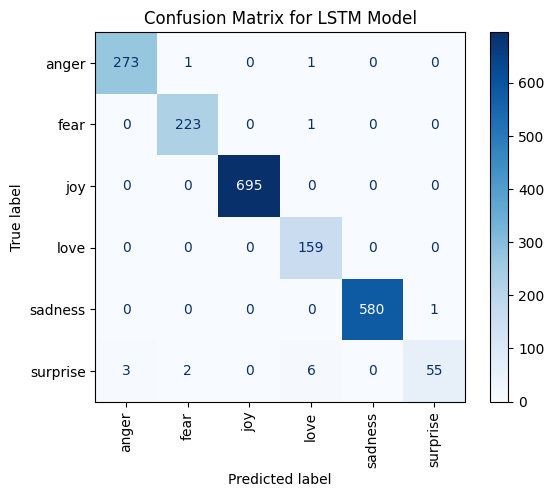

In [19]:
cm = confusion_matrix(y_test,y_pred)
emotion_labels = labelEncoder.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical')
plt.title("Confusion Matrix for LSTM Model")
plt.show()